# Perspective Transform

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
# Download and unzip our images 
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip

!unzip -qq images.zip

--2022-09-02 13:31:44--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.142.14
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.142.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29586716 (28M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  28.22M  19.7MB/s    in 1.4s    

2022-09-02 13:31:46 (19.7 MB/s) - ‘images.zip’ saved [29586716/29586716]



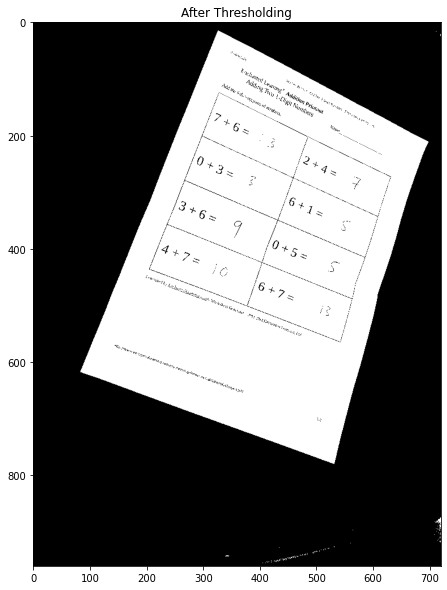

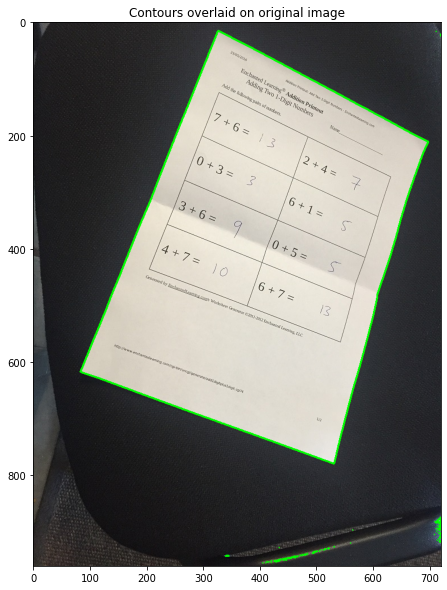

Number of Contours Found :54


In [3]:
image = cv2.imread('images/scan.jpg')

#Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, th2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imshow('After Thresholding', th2)

#Use a copy of your image 
contours, hierarchy = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Draw all contours
#use "-1" as third parameter to draw all
cv2.drawContours(image, contours, -1, (0,255,0), thickness = 2)
imshow("Contours overlaid on original image", image)

print("Number of Contours Found :" + str(len(contours)))

#### Approximate Contour above to just 4 points using approxPolyDP

In [4]:
#Sort Contours large to small
sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)

#Loop over the contours
for cnt in sorted_contours:
  #approximate the contour
  perimeter = cv2.arcLength(cnt, True)
  approx = cv2.approxPolyDP(cnt, 0.05 * perimeter, True)

  if len(approx) == 4:
    break

#Our x, y cordinates of the 2 corner
print("4 Corner points are")
print(approx)

4 Corner points are
[[[326  15]]

 [[ 83 617]]

 [[531 779]]

 [[697 211]]]


#### getPerspectiveTransform and warpPerspective to create top-down view

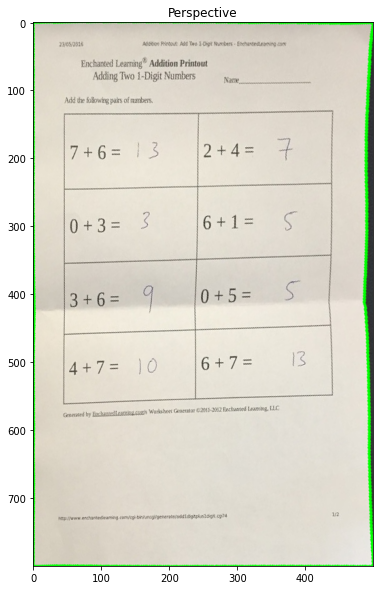

In [5]:
#Order obtained here is top left, bottom left, bottom right and top right
inputPts = np.float32(approx)

outputPts = np.float32([[0,0],
                        [0,800],
                        [500,800],
                        [500,0]])

#Transformation Matrix
M = cv2.getPerspectiveTransform(inputPts, outputPts)

#Apply the transform using Matrix M using warpPerspective
dst = cv2.warpPerspective(image, M, (500, 800))

imshow("Perspective", dst)

# Histograms and K means Clustering for Dominant Colors

* See the RGB Histogram representation of an Image
* Use K-Means Clustering to get dominant colors and their propotions in Images

cv2.calcHist(Images, channels, mask, histSize, ranges[, histp[, accumulate])

* **Images** - Source Image in uint8 or float32, in square brackets [img]
* **Channels** - Index of channel for which we calculate Histogram(If input is grayscale, value is [0]. For Color Image you can pass [0], [1] or [2] to calculate histogram of blue, green and red respectively)
* **mask** - To find Histogram of full image, it is given as None. If you want to get Histogram of particular region You have to pass in the mask
* **histSize** - Represents BIN count, To be given in Square Bracket, for Full Scale we pass [256]
* **ranges** - normally it is [0,256]


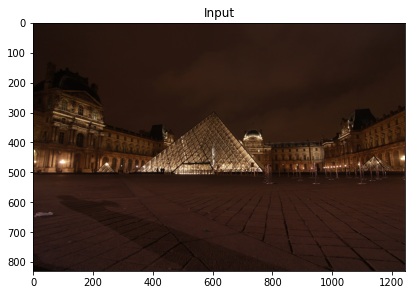

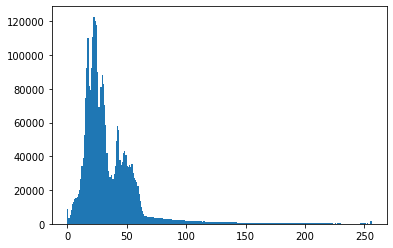

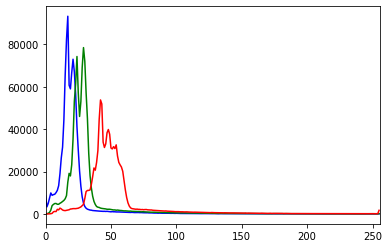

In [7]:
image = cv2.imread('images/input.jpg')
imshow('Input', image)

#histogram = cv2.calcHist([image], [0], None, [256], [0,256])

#We plot a Histogram, ravel() flattens our image array
plt.hist(image.ravel(), 256, [0, 256]); plt.show()

#Viewing Separate channels
color = ('b', 'g', 'r')

#Separate Colors and plot each in the Histogram
for i, col in enumerate(color):
  histogram2 = cv2.calcHist([image], [i], None, [256], [0,256])
  plt.plot(histogram2, color = col)
  plt.xlim([0,256])

plt.show()

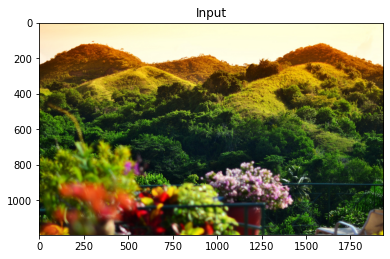

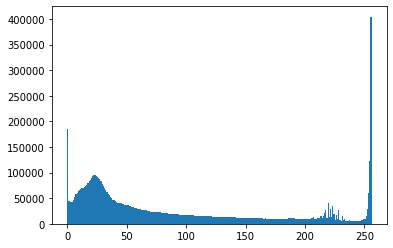

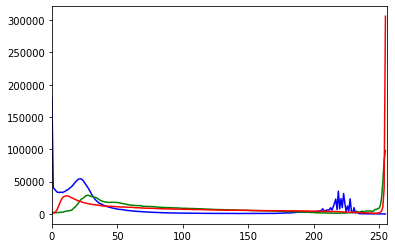

In [8]:
image = cv2.imread('images/tobago.jpg')
imshow('Input', image)

histogram = cv2.calcHist([image], [0], None, [256], [0,256])

#We plot a Histogram, ravel() flattens our image array
plt.hist(image.ravel(), 256, [0, 256]); plt.show()

#Viewing Separate channels
color = ('b', 'g', 'r')

#Separate Colors and plot each in the Histogram
for i, col in enumerate(color):
  histogram2 = cv2.calcHist([image], [i], None, [256], [0,256])
  plt.plot(histogram2, color = col)
  plt.xlim([0,256])

plt.show()

# K-means Clustering to Obtain the dominant colors in an Image



In [12]:
def centroidHistogram(clt):
  #Create Histogram based on Clusters on Pixel
  #Get label for each cluster
  numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)

  #Creating out Histogram
  (hist, _) = np.histogram(clt.labels_, bins = numLabels)

  #Normalize the Histogram, so that it sums to one
  hist = hist.astype("float")
  hist /= hist.sum()

  return hist

def plotColors(hist, centroids):
  #create our blank barchart
  bar = np.zeros((100, 500, 3), dtype = "uint8")

  x_start = 0
  #iterate over the percentage and dominant of each color
  for (percent, color) in zip(hist, centroids):
    #plot the relative percentage of each cluster
    end = x_start + (percent * 500)
    cv2.rectangle(bar, (int(x_start), 0), (int(end), 100),
                  color.astype("uint8").tolist(), -1)
    x_start = end
  return bar

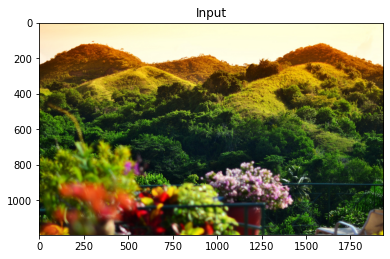

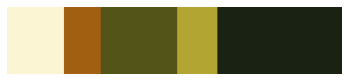

In [13]:
from sklearn.cluster import KMeans

image = cv2.imread('images/tobago.jpg')
imshow("Input", image)

# Reshaping image into list of RGB pixels
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.reshape((image.shape[0] * image.shape[1], 3))

number_of_clusters = 5
clt = KMeans(number_of_clusters)
clt.fit(image)

hist = centroidHistogram(clt)
bar = plotColors(hist, clt.cluster_centers_)

#Color Bar
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()